# <div align='center'><i>Visualizing CNNs</i></div>

In [2]:
import cv2
import numpy as np
import tensorflow as tf
from keras import models
import matplotlib.pyplot as plt
from keras.preprocessing import image
from matplotlib.gridspec import GridSpec
from tensorflow.keras import backend as K
from tensorflow.python.framework import ops
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions

%matplotlib inline

In [3]:
def build_model(Type):
    
    """Function returning keras model instance."""
    
    # Normal VGG-16 model
    if(Type == "normal"):
        return VGG16(include_top=True,weights='imagenet')
    
    # Guided Backpropagation
    elif(Type == "GBP"):
        
        if "GuidedBackProp" not in ops._gradient_registry._registry:
            @ops.RegisterGradient("GuidedBackProp")
            def _GuidedBackProp(op, grad):
                dtype = op.inputs[0].dtype
                return grad * tf.cast(grad > 0., dtype) * \
                   tf.cast(op.inputs[0] > 0., dtype)
        
        tf.compat.v1.disable_eager_execution()
        g = tf.compat.v1.get_default_graph()
        with g.gradient_override_map({'Relu': 'GuidedBackProp'}):
            new_model = build_model('normal')
        return new_model   
    
    # Network In Networks
    elif(Type == "NN"):
        return models.load_model('./Files/Model_v1.h5')
    
def load_image(img_path,Type):
    
    # The NN model that I am using expects a (150x150x3) image
    if(Type == "NN"):
        
        img = image.load_img(img_path,target_size=(150,150))
        # Preprocess the image as it was done for training the Model
        img_tensor = image.img_to_array(img)
        # Adding the batch_size dimention
        img_tensor = np.expand_dims(img_tensor, axis=0) 
        # Normalizing
        img_tensor /= 255.
        
        return img_tensor
    
    # The VGG-16 model expects a (224x224x3) image
    elif(Type == None):
        
        img = image.load_img(img_path, target_size=(224, 224))
        img_tensor = image.img_to_array(img)
        img_tensor = np.expand_dims(img_tensor, axis=0)
        img_tensor = preprocess_input(img_tensor)
        
        return img_tensor

def process(heatmap, img_path,label):
    
    if(label=="GBP"):
        
        heatmap = heatmap.copy()
        if(np.ndim(heatmap) > 3):
            heatmap = np.squeeze(heatmap)
        # normalize tensor: center on 0., ensure std is 0.1
        heatmap -= heatmap.mean()
        heatmap /= (heatmap.std() + 1e-5)
        heatmap *= 0.1

        # clip to [0, 1]
        heatmap += 0.5
        heatmap = np.clip(heatmap, 0, 1)
        
        # convert to RGB array
        heatmap *= 255
        heatmap = np.clip(heatmap, 0, 255).astype('uint8')
        
        return heatmap
        
        
    else:
        
        img = cv2.imread(img_path)
        img = cv2.resize(img,(224,224))
        heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
        heatmap = np.uint8(255 * heatmap)
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
        superimposed_img = heatmap*0.6 + img
        cv2.imwrite('./Files/{}.jpg'.format(label), superimposed_img.astype(np.uint16))
        
        return heatmap


#### Load Model & Input 

In [4]:
model_n = build_model('normal')
model_GBP = build_model('GBP')
model_NN = build_model('NN')

img_path = './Files/d.png'
input_img1 = load_image(img_path,None)
input_img1_NN = load_image(img_path,'NN')

## Technique-1: <i>Saliency Mapping</i> 

### Method-1: Saliency Map

In [13]:
def Saliency_M(input_model, img):
    
    """Backpropagation method for visualizing input saliency."""
    
    # Predicted class
    cls = np.argmax(input_model.predict(img))
    model_output = K.function([input_model.input],[input_model.output])
    # Class score before applying softmax
    yc = input_model.output.op.inputs[0][0,cls]
    # Gradient of the class score wrt to input image
    grads = K.gradients(yc, input_model.input)[0]
    backprop_fn = K.function([input_model.input, K.learning_phase()], [grads])
    grad_vals = backprop_fn([img,0])[0]
    
    Smap = np.maximum(grad_vals[0], 0)
    Smap = np.max(Smap, axis=-1)
    
    return Smap

### Method-2: Guided Backpropagation

In [66]:
def guided_backprop(input_model, images, layer_name):
    
    """Guided Backpropagation method for visualizing input saliency."""
    
    input_imgs = input_model.input
    layer_output = input_model.get_layer(layer_name).output
    # Gradient of the given output layer wrt to input image
    grads = K.gradients(layer_output, input_imgs)[0]
    backprop_fn = K.function([input_imgs, K.learning_phase()], [grads])
    grads_val = backprop_fn([images, 0])[0]
    
    return grads_val

### Visualizing Class Saliency Mapping

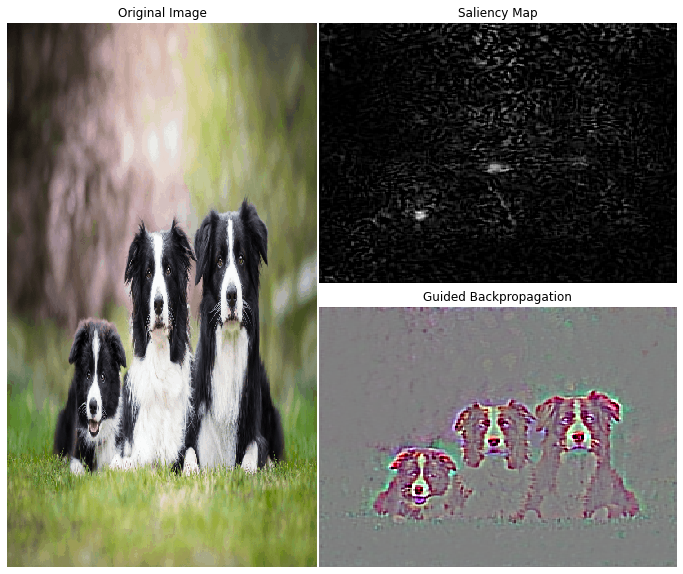

In [65]:
fig_1 = plt.figure(figsize=(10,10),constrained_layout=False)
gs_1 = fig_1.add_gridspec(nrows=1, ncols=1, left=0.05, right=0.48,
                        wspace=0)
gs_2 = fig_1.add_gridspec(nrows=2, ncols=1, left=0.483, right=0.98,
                        hspace=0.09)

# Original Image
axs = fig_1.add_subplot(gs_1[:,-1])
img = plt.imread(img_path)
axs.imshow(img)
axs.title.set_text('Original Image')
axs.axis('off')
axs.grid(True)
axs.imshow(img,interpolation='nearest')
axs.set_aspect('auto')

# Saliency Map
axs1 = fig_1.add_subplot(gs_2[0,-1])
axs1.title.set_text('Saliency Map')
axs1.axis('off')
axs1.imshow(Saliency_M(model_n,input_img1),cmap='gray',interpolation='nearest')
axs1.set_aspect('auto')

# Guided Backpropagation
axs2 = fig_1.add_subplot(gs_2[1,-1])
axs2.title.set_text('Guided Backpropagation')
axs2.axis('off')
axs2.imshow( process(guided_backprop(model_GBP,input_img1,'block5_conv3'),None,'GBP'),
                                        interpolation='nearest')
axs2.set_aspect('auto')

plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig('./Files/Saliency-Mapping.png')
plt.show()

## Technique-2: <i>Class Activation Mapping</i> 

### Method-1: CAM

In [61]:
def CAM(input_model, img):
    
    # Predicted class
    cls = np.argmax(input_model.predict(img))
    
    # get_weights() retuns a list [weights,bias]
    # [:,cls] returns Weights corresponding to the predicted class
    # ie weights btw GAP and Dense layer corresponding to the predicted class
    Weights = input_model.layers[12].get_weights()[0][:,cls]
    
    # Last convolutional layer
    # Here we are taking output[0] to remove the batch dimention
    LCL = input_model.layers[10].output[0]
    
    # Function to return the output of last convolutional layer give an input
    LCL_OutPut = K.function([input_model.input, K.learning_phase()], [LCL])
    
    # Output of last convolutional layer given the input
    # Returns a list tensor of size 1 
    #in [img,0] here 0 corresponds to testing mode
    OutPut = LCL_OutPut([img,0])[0]
    
    # Class Activation Map
    CAM = np.zeros_like(OutPut)
    
    n_channels = OutPut.shape[-1]
    for depth in range(n_channels):
        CAM[:,:,depth] = OutPut[:,:,depth] * Weights[depth]
        
    # Sum the values along the depth axis
    CAM = np.sum(CAM, axis=-1)
    
    # Postprocessing to make the Visualization more clear
    CAM = np.maximum(CAM, 0)
    CAM /= np.max(CAM)
    
    return CAM

### Method-2: Grad-CAM

In [62]:
def GCAM(input_model, img, layer_name):
    
    # Predicted class
    cls = np.argmax(input_model.predict(img))
    
    #class score before applying softmax
    yc = input_model.output.op.inputs[0][0,cls]
    
    # Last convolutional layer
    last_conv_layer = input_model.get_layer(layer_name)
    # gradient of the class score wrt to Last convolutional layer
    grads = K.gradients(yc, last_conv_layer.output)[0]
    
    # sum or mean the gards along the depth channel
    pooled_grads = K.mean(grads, axis=(0,1,2))
    iterate = K.function([input_model.input],[pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([img])
    
    n_channels = conv_layer_output_value.shape[-1]
    for depth in range(n_channels):
        conv_layer_output_value[:, :, depth] *= pooled_grads_value[depth]
    
    GCam = np.mean(conv_layer_output_value, axis=-1)
    
    # Postprocessing to make the Visualization more clear
    GCam = np.maximum(GCam, 0)
    GCam /= np.max(GCam)
    
    return GCam

### Method-3: Grad-CAM++

In [63]:
def GCAMpp(input_model, img, layer_name):
    
    # Predicted class
    cls = np.argmax(input_model.predict(img))
    
    #class score after applying softmax
    yc = input_model.output[0, cls]
    
    # Last convolutional layer
    conv_output = input_model.get_layer(layer_name).output
    # gradient of the class score wrt to Last convolutional layer
    grads = K.gradients(yc, conv_output)[0]
    gradient_function = K.function([input_model.input], [conv_output, grads])
     
    output, grads_val = gradient_function([img])
    output, grads_val = output[0, :], grads_val[0, :, :, :]
    grads_val = np.maximum(grads_val,0)
    
    weights = np.mean(grads_val, axis=(0, 1))
    gcampp = np.dot(output, weights)
    
    # Postprocessing to make the Visualization more clear
    gcampp = cv2.resize(gcampp, (224, 224), cv2.INTER_LINEAR)
    gcampp = np.maximum(gcampp, 0)
    gcampp = gcampp / gcampp.max()
    
    return gcampp

### Visualizing Class Activation Mapping

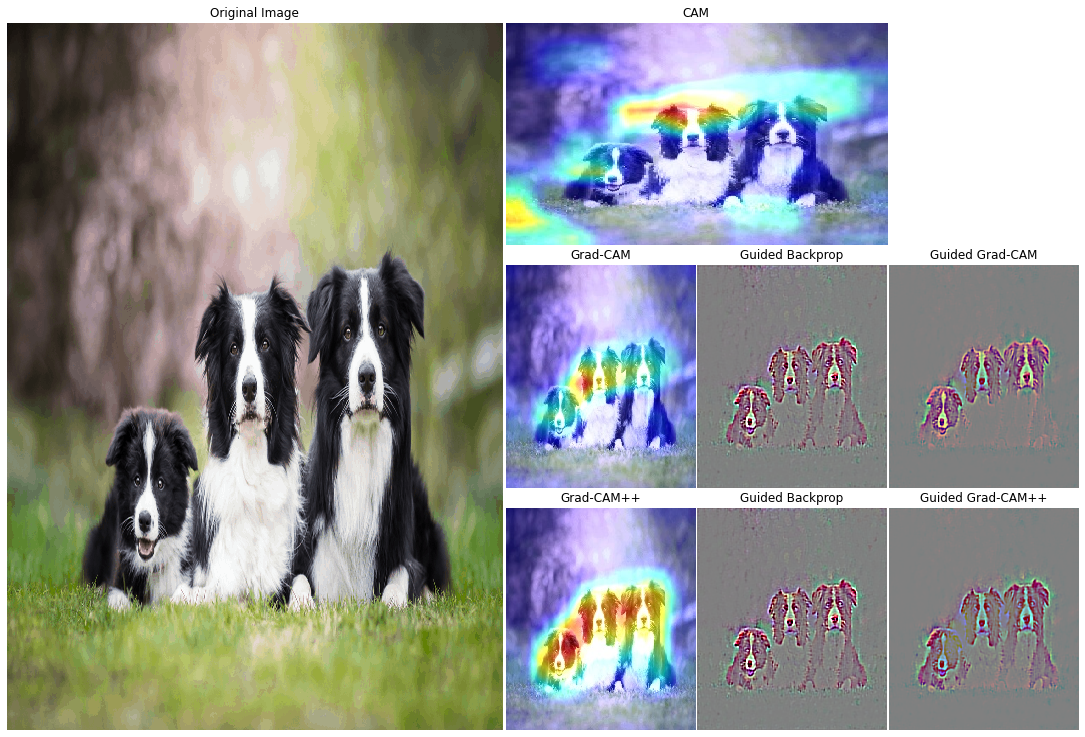

In [64]:
cam = process(CAM(model_NN,input_img1_NN),img_path,'CAM')
gcam = process(GCAM(model_n,input_img1,'block5_conv3'),img_path,'GCAM')
gcampp = process(GCAMpp(model_n,input_img1,'block5_conv3'),img_path,'GCAM++')
gbp = process(guided_backprop(model_GBP,input_img1,'block5_conv3'),None,'GBP')

img = plt.imread(img_path)
fig = plt.figure(figsize=(16,13),constrained_layout=False)
gs1 = fig.add_gridspec(nrows=1, ncols=1, left=0.05, right=0.48,
                        wspace=0.05)
gs2 = fig.add_gridspec(nrows=3, ncols=5, left=0.15, right=0.98,
                        hspace=0.09)

# Original Image
ax0 = fig.add_subplot(gs1[:,-1])
ax0.title.set_text('Original Image')
ax0.axis('off')
ax0.grid(True)
ax0.imshow(img,interpolation='nearest')
ax0.set_aspect('auto')


# CAM
ax01 = fig.add_subplot(gs2[0,2:-1])
imgc = plt.imread('./Files/CAM.jpg')
ax01.title.set_text('CAM')
ax01.axis('off')
ax01.imshow(imgc,interpolation='nearest')
ax01.set_aspect('auto')

# Grad-CAM
ax11 = fig.add_subplot(gs2[1,2:3])
imggc = plt.imread('./Files/GCAM.jpg')
ax11.title.set_text('Grad-CAM')
ax11.axis('off')
ax11.imshow(imggc,interpolation='nearest')
ax11.set_aspect('auto')

# Guided Backprop
ax12 = fig.add_subplot(gs2[1,3:4])
ax12.title.set_text('Guided Backprop')
ax12.axis('off')
ax12.imshow(gbp,interpolation='nearest')
ax12.set_aspect('auto')

# Guided Grad-CAM
ax13 = fig.add_subplot(gs2[1,4:])
x = guided_backprop(model_GBP,input_img1,'block5_conv3')
guided_gradcam = x[0] * gcam
ax13.imshow(process(guided_gradcam,None,'GBP'))
ax13.title.set_text('Guided Grad-CAM')
ax13.axis('off')
ax13.set_aspect('auto')

# Grad-CAM++
ax21 = fig.add_subplot(gs2[2,2:3])
imgc = plt.imread('./Files/GCAM++.jpg')
ax21.title.set_text('Grad-CAM++')
ax21.axis('off')
ax21.imshow(imgc,interpolation='nearest')
ax21.set_aspect('auto')


# Guided Grad-CAM
ax22 = fig.add_subplot(gs2[2,3:4])
ax22.title.set_text('Guided Backprop')
ax22.axis('off')
ax22.imshow(gbp,interpolation='nearest')
ax22.set_aspect('auto')

# Guided Grad-CAM++
ax23 = fig.add_subplot(gs2[2,4:])
x = guided_backprop(model_GBP,input_img1,'block5_conv3')
guided_gradcam = x[0] * gcampp
ax23.imshow(process(guided_gradcam,None,'GBP'))
ax23.title.set_text('Guided Grad-CAM++')
ax23.axis('off')
ax23.set_aspect('auto')

plt.subplots_adjust(wspace=0.01, hspace=0)
plt.savefig('./Files/CAM-Mapping.png')
plt.show()